In [11]:
import gym
import numpy as np
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
tf.disable_v2_behavior() # 텐서플로우 버전 1 함수 사용 

In [12]:
env = gym.make('FrozenLake-v0')

In [26]:
input_size = env.observation_space.n
output_size = env.action_space.n
learning_rate = 0.1

In [27]:
X = tf.placeholder(shape=[1, input_size], dtype=tf.float32) # 입력층 
W = tf.Variable(tf.random_uniform([input_size, output_size], 0, 0.01)) # 학습할 파라미터
Qpred = tf.matmul(X, W) # 결과 
Y = tf.placeholder(shape=[1, output_size], dtype=tf.float32) # 레이블 

In [28]:
loss = tf.reduce_sum(tf.square(Y-Qpred)) # 제곱오차 
train = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)
init = tf.global_variables_initializer()

In [29]:
dis = 0.99
num_episode = 2000
rList = []

In [30]:
def one_hot(x): # 입력 데이터를 one-hot encoding으로 변환 
    return np.identity(input_size)[x:x+1] # identity 행렬 만들고 그중 x번째 행 선택 

In [33]:
with tf.Session() as sess:
    sess.run(init) # 초기화 
    for i in range(num_episode):
        if i%400==0:
            print("Episode: "+str(i))
        
        state = env.reset()
        e = 1.0/((i/50)+10) # E-Greedy 알고리즘 사용 
        rAll = 0
        done = False
        local_loss = []
        
        while not done:
            Qs = sess.run(Qpred, feed_dict={X: one_hot(state)}) # 신경망 결과값 계산
            action = np.argmax(Qs) # 신경망 결과로 action 선택 
            if np.random.rand(1) < e: # E-Greedy
                action = env.action_space.sample() # action 아무거나 선택
            
            state_next, reward, done, _ = env.step(action) # 선택한 action으로 다음 스텝 진행
            if done: # 만약 도착지점이라면 Q를 reward로 설정 
                Qs[0, action] = reward
            else: # 아니라면 Q(state) = reward * dis*Q(next state) 로 Q 업데이트 
                Qs_next = sess.run(Qpred, feed_dict={X: one_hot(state_next)})
                Qs[0, action] = reward + dis*np.max(Qs_next)
                
            sess.run(train, feed_dict={X: one_hot(state), Y:Qs})
            
            rAll += reward
            state = state_next
            
        rList.append(rAll)

Episode: 0
Episode: 400
Episode: 800
Episode: 1200
Episode: 1600


Successful episodes: 60.5%


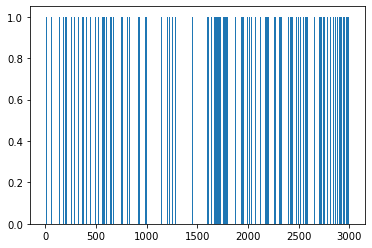

In [36]:
print("Successful episodes: "+str(sum(rList)*100/num_episode)+"%")
plt.bar(range(len(rList)), rList)
plt.show()